<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg" 
     width="30%" 
     align=right
     alt="Dask logo">

Custom ETL
----------

This notebook mimics a custom ETL process.  It exemplifies a ubiquitous problem that is both amenable to parallelism and often tricky.

It goes through the following steps:

1.  Load in several independent datasets
2.  Load in a reference dataset
3.  Clean each dataset with the reference
4.  "Roll" the data, considering every triplet dataset in a sliding window
5.  Randomly select pairs of these and measure some performance metric
6.  Select the best pair

### Build normal Python functions

In [1]:
import random
from time import sleep

def load(address):
    sleep(random.random() / 2)
    pass

def load_from_sql(address):
    sleep(random.random() / 1 + 1)
    pass

def process(data, reference):
    sleep(random.random() / 2)
    pass

def roll(a, b, c):
    sleep(random.random() / 5)
    pass

def compare(a, b):
    sleep(random.random() / 10)
    pass

def reduction(seq):
    sleep(random.random() / 1)
    pass 



### Integrate normal Python functions with Dask

In [2]:
from dask import delayed

load = delayed(load)
load_from_sql = delayed(load_from_sql)
process = delayed(process)
roll = delayed(roll)
compare = delayed(compare)
reduction = delayed(reduction)

In [3]:
filenames = ['mydata-%d.dat' % i for i in range(10)]

data = [load(fn) for fn in filenames]

reference = load_from_sql('sql://mytable')

processed = [process(d, reference) for d in data]

rolled = []
for i in range(len(processed) - 2):
    a = processed[i]
    b = processed[i + 1]
    c = processed[i + 2]
    r = roll(a, b, c)
    rolled.append(r)
    
compared = []
for i in range(20):
    a = random.choice(rolled)
    b = random.choice(rolled)
    c = compare(a, b)
    compared.append(c)
    
best = reduction(compared)

### Visualize Computation

There is clearly parallelism here, but it's not in any standard form.

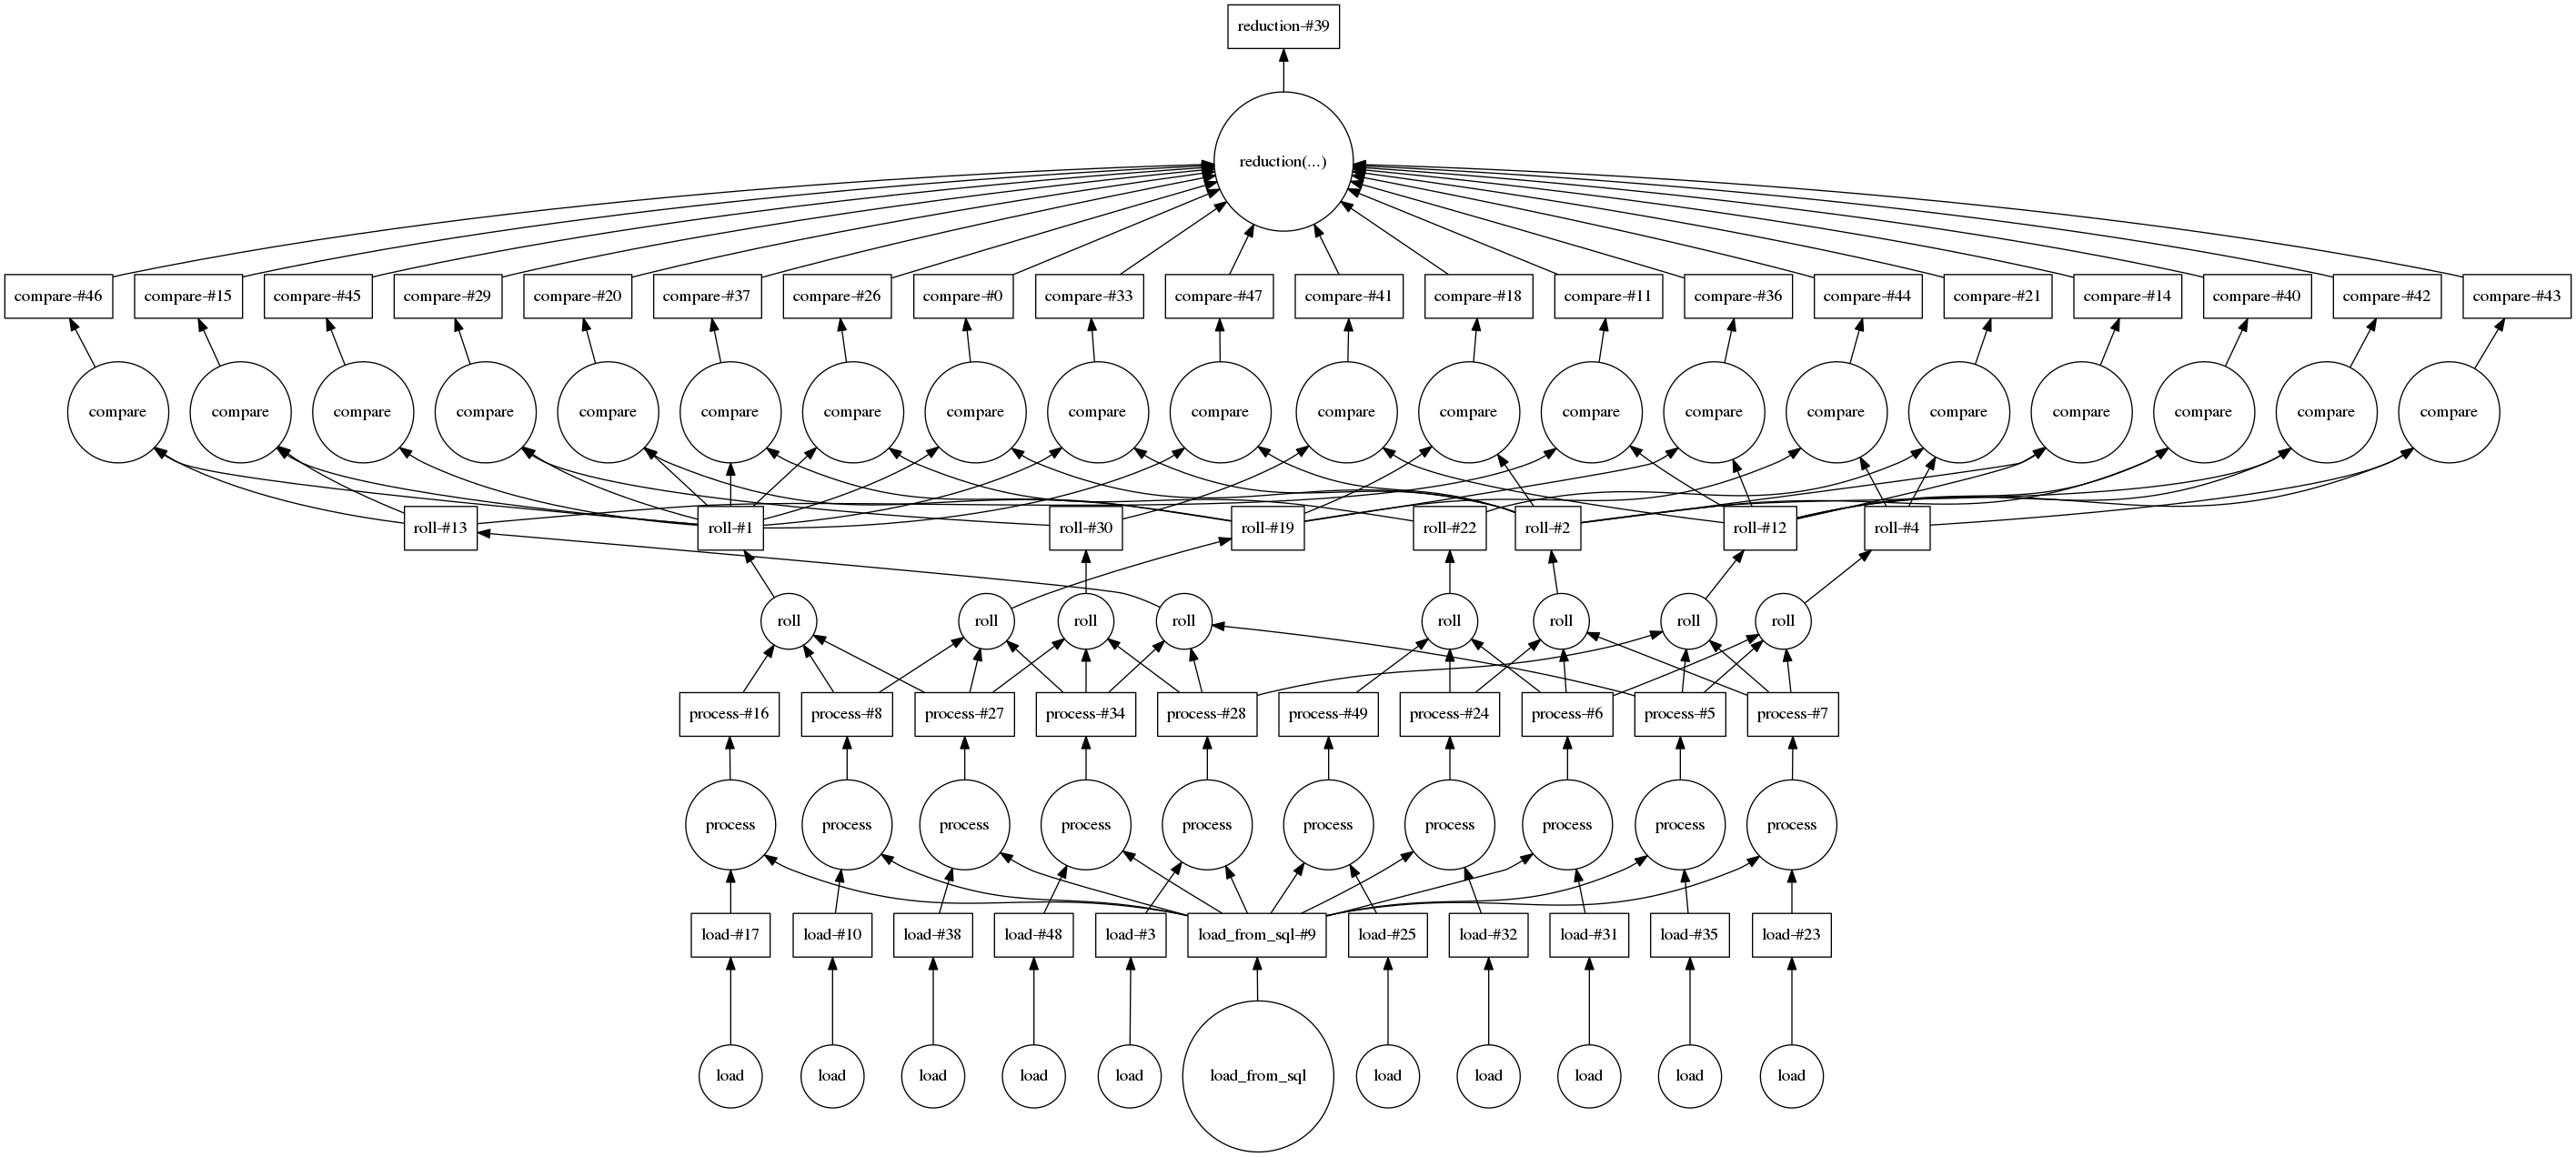

In [4]:
best.visualize()

### Connect and Compute

In [5]:
from dask.distributed import Client, progress

client = Client('localhost:8786')

future = client.compute(best)

### Larger Example

In [6]:
filenames = ['mydata-%d.dat' % i for i in range(100)]

data = [load(fn) for fn in filenames]

reference = load_from_sql('sql://mytable')
processed = [process(d, reference) for d in data]

rolled = []
for i in range(len(processed) - 2):
    a = processed[i]
    b = processed[i + 1]
    c = processed[i + 2]
    r = roll(a, b, c)
    rolled.append(r)
    
compared = []
for i in range(1000):
    a = random.choice(rolled)
    b = random.choice(rolled)
    c = compare(a, b)
    compared.append(c)
    
best = reduction(compared)

In [7]:
future2 = client.compute(best)

### Final Thoughts

*  Dask exposes parallelism present in normal code
*  Messy problems are common.  It's useful to think without map/filter/groupby/join sometimes.